In [1]:
import os
import sys
import copy
import random
import json
from tqdm import tqdm, trange

In [2]:
import numpy as np
import cv2
import albumentations as alb

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Load dataset

In [5]:
def get_image_level(image_path, mask_path, size=(256, 256), aug=None, pad=48, border=128):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)[:,:,0]
    h, w = mask.shape

    levels = np.max(mask)
    if aug:
        sample = aug(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    half_size = int(mask.shape[0] / 2)
    sh, sw = half_size, None
    for i in range(mask.shape[1]):
        v = mask[half_size, i]
        if v != 0:
            sw = i
            break
    if sw is None:
        raise ValueError('Object box not found')
    
    h1, h2 = int(sh - size[0] / 2), int(sh + size[0] / 2)
    w1, w2 = int(sw - size[1] / 2), int(sw + size[1] / 2)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (border, border))
    image_mask = mask.copy()
    image_mask = cv2.dilate(image_mask, kernel, iterations=1).clip(0, 1)
    image = image * np.stack([image_mask, image_mask, image_mask], axis=-1)

    mask = mask[h1:h2, w1:w2]
    
    result = image.copy()[h1:h2, w1:w2, :]
    return result, levels

In [6]:
image_prefix = 'i_'
mask_prefix = 'm_'

# Let's fileter data
min_level = 1
max_level = 256

folder_list = ['/home/user3/work/data/by_z_regression/hrodna_t/known_dataset', ]

dataset_files = []
for k, folder in enumerate(folder_list, start=1):
    print('Started', k, 'of', len(folder_list))
    dataset_name = folder.split('_')[-1]
    dataset_items = [fn[len(mask_prefix): ] for fn in os.listdir(folder) if os.path.isfile(os.path.join(folder, fn)) and fn.startswith(mask_prefix)]
    for n in trange(len(dataset_items)):
        dataset_item = dataset_items[n]
        ip, mp = (os.path.join(folder, image_prefix + dataset_item), os.path.join(folder, mask_prefix + dataset_item))
        try:
            i, l = get_image_level(ip, mp)
            l = float(l)
            if l < min_level:
                print('Skipped with level < min level', ip)
                continue
            if l > max_level:
                print('Skipped with level > max level', ip)
                continue
            if i.shape[0] != 256 or i.shape[1] != 256:
                print('Skipped with shape != 256', ip)
                continue
        except Exception as e:
            continue
        dataset_files.append((ip, mp, dataset_name, int(l)))

Started 1 of 1


  5%|██                                     | 720/13935 [00:29<08:24, 26.19it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_25263-25607-0-167-1.tif


 12%|████▍                                 | 1605/13935 [01:05<08:47, 23.35it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_25260-25601-0-226-1.tif


 15%|█████▌                                | 2033/13935 [01:22<07:58, 24.87it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_24819-25173-0-246-1.tif


 18%|██████▊                               | 2508/13935 [01:41<07:12, 26.41it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_25071-25411-0-227-1.tif


 27%|██████████▎                           | 3779/13935 [02:33<06:29, 26.10it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_25261-25601-0-282-1.tif


 35%|█████████████▏                        | 4843/13935 [03:16<05:44, 26.41it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_24715-25050-0-217-1.tif


 35%|█████████████▎                        | 4861/13935 [03:17<05:55, 25.52it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_24938-25273-0-227-1.tif


 53%|███████████████████▉                  | 7329/13935 [04:55<04:42, 23.38it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_25028-25362-0-227-1.tif


 73%|███████████████████████████          | 10182/13935 [06:48<02:32, 24.65it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_25121-25458-0-227-1.tif


 83%|██████████████████████████████▌      | 11520/13935 [07:41<01:28, 27.34it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_24716-25048-0-274-1.tif


 92%|██████████████████████████████████▏  | 12884/13935 [08:35<00:38, 27.53it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_25169-25506-0-215-1.tif


 95%|███████████████████████████████████▏ | 13241/13935 [08:49<00:25, 26.70it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_16461-16792-21987-22264-1.tif


 96%|███████████████████████████████████▌ | 13385/13935 [08:55<00:19, 28.48it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/hrodna_t/known_dataset/i_24939-25273-0-165-1.tif


100%|█████████████████████████████████████| 13935/13935 [09:17<00:00, 24.98it/s]


In [7]:
class InferDataset(BaseDataset):
    
    def __init__(self, dataset_files):
        self.dataset_files = dataset_files
        self.pad = 48
        self.border = 128
        self.output_size = (256, 256)
    
    def __getitem__(self, i):
        a = self.dataset_files[i]
        image_path, mask_path, ds, lv = a
        name = image_path.split('/')[-1].split('_')[1].split('.')[0]

        # Image
        image, levels = get_image_level(image_path, mask_path,
                                       size=self.output_size,
                                       aug=None, pad=self.pad, border=self.border)
            
        return image, levels, name
        
    def __len__(self):
        return len(self.dataset_files)

1
8658-8984-7390-7721-1


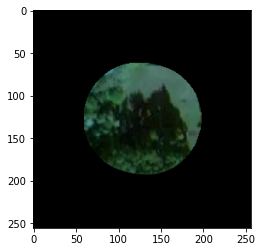

In [8]:
# Lets look at data we have
infer_dataset = InferDataset(dataset_files)
image, level, name = infer_dataset[random.randint(0, len(infer_dataset))] # get some sample
print(level)
print(name)
plt.imshow(image)
plt.show()

In [9]:
def preprocess_f(x):
    x = x.float()

    x.div_(255.0)

    x[:,0, :, :].add_(-0.485)
    x[:,1, :, :].add_(-0.456)
    x[:,2, :, :].add_(-0.406)

    x[:,0, :, :].div_(0.229)
    x[:,1, :, :].div_(0.224)
    x[:,2, :, :].div_(0.225)
    return x


def calc_euclidean(x1, x2):
    return (x1 - x2).pow(2).sum()


class AdaptivePoolingHead(nn.Sequential):
    def __init__(self, pooling="avg"):
        if pooling not in ("max", "avg"):
            raise ValueError("Pooling should be one of ('max', 'avg'), got {}.".format(pooling))
        pool = nn.AdaptiveAvgPool2d(1) if pooling == 'avg' else nn.AdaptiveMaxPool2d(1)
        super().__init__(pool)

class OsmNet(torch.nn.Module):
    def __init__(self, source_model, backbone_channels=512, num_classes=16):
        super(OsmNet, self).__init__()
        self.source_model = source_model
        # self.head = ClassificationHead(backbone_channels, 1)
        # self.head = RegressionHead(backbone_channels)

    def forward(self, x):
        x = x.float()
        x = preprocess_f(x)
        x = self.source_model.forward_features(x)
        # x = self.head(x)
        return x


net = OsmNet(timm.create_model('vgg11'))

In [10]:
CUDA = "cuda:0"
CPU = "cpu"
device = torch.device(CUDA) # if torch.cuda.is_available() else CPU)

In [11]:
net.load_state_dict(torch.load('./_best_vgg11.pth', map_location=CUDA))
net = net.to(device)

In [12]:
last_features = None
last_level = None
last_image = None

In [13]:
# Lets look at data we have
show_im = True
results = []

image, levels, name = infer_dataset[random.randint(0, len(infer_dataset))] # get some sample

features = None
with torch.no_grad():
    image_np = image
    image = torch.tensor(image.copy(), dtype=torch.float)
    image = torch.unsqueeze(image.to(device), 0)
    image = torch.transpose(image, 1, 3)
    features = net(image)

if last_features is not None:
    distance = float(calc_euclidean(features, last_features))
else:
    distance = None
    
if last_features is not None:
    print(distance)
    print(levels)
    plt.imshow(image_np)
    plt.show()
    
    print(last_level)
    plt.imshow(last_image)
    plt.show()
    
    
last_features = features
last_level = levels
last_image = image_np

In [14]:
# Lets look at data we have
output_path = '/home/user3/work/data/by_z_regression/hrodna_t/known_dataset'
features_prefix = 'f_'
features_ext = '.npy'

for n in trange(len(infer_dataset)-1):
    image, levels, name = infer_dataset[n] # get some sample
    with torch.no_grad():
        image_np = image
        image = torch.tensor(image.copy(), dtype=torch.float)
        image = torch.unsqueeze(image.to(device), 0)
        image = torch.transpose(image, 1, 3)
        features = net(image)
        features = features.detach().cpu().numpy()
        
        features_path = os.path.join(output_path, features_prefix + name + features_ext)
        with open(features_path, 'wb') as f:
            np.save(f, features)

100%|█████████████████████████████████████| 13866/13866 [11:49<00:00, 19.55it/s]
